# README

We are analyzing the preFilter algorithm that we have developed in this code. We are looking at how increasing the number of biX curves changes the MSE result that we observe.

# Libraries

In [16]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools

# Initialize Parameters

In [17]:
####### Options #######
randStart = True                  #Initial guess for parameter values in random locations

In [18]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.4
c2 = 0.6 
T21 = 40
T22 = 100

true_params = np.array([T11, T12, c1, c2, T21, T22])

#Building the TE array - this should be a uniform array
n_points = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_points, n_points) #ms units

assert(TE_DATA[-1] == 512)
d_TE = np.mean(np.diff(TE_DATA))
assert(d_TE == 8)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12


######### Total TI - a subset of these points are used to show how the MSE varies depending on the number of TI points
#These points were selected using a 
TI_DATA_total = np.array([390, 850, 0, 50, 100, 150, 200])#, 250, 300, 500, 550, 600, 750])#])#

#SNR Value to Evaluate
SNR_value = 100

#Parameters that dictate process related features
var_reps = 1000          #number of times we iterate the full test

#number of multistarts in the BIC filter to ensure accurate measurement
multi_starts_BIC = 3

if randStart:
    multi_starts_obj = 2
else:
    multi_starts_obj = 1

#number of iterations to evaluate consistency of BIC filter
BIC_eval_iter = 100     

#Builds a string of parameters to use in the titles
ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
round_Params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [19]:
#Defining the function of interest

def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def S_moX_3p(TE, T1, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [20]:
def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (2, 2, 0, 0, 2, 2)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (2, 0, 2)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 2, 2)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 2)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("T21","T22","c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("T21","c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

In [21]:
def BIC_opt1(RSS, TE_array, p_list, sigma):

    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def BIC_opt2(RSS, TE_array, p_list):

    BIC = len(TE_array) * np.log(RSS/len(TE_array)) + len(p_list) * np.log(len(TE_array))

    return BIC

def evaluate_model(data, ms_iter = multi_starts_BIC):

    #Returns true if the moX is better than the biX --> returns a 1 for moX and a 0 for biX
    #Returns the parameters of the correct answer

    RSS_biX = np.inf
    RSS_moX = np.inf

    for ms in range(ms_iter):
        popt_biX_temp, RSS_biX_temp = estP_oneCurve(S_biX_4p, data)
        popt_moX_temp, RSS_moX_temp = estP_oneCurve(S_moX_2p, data)

        if RSS_biX_temp < RSS_biX:
            popt_biX = popt_biX_temp
            RSS_biX = RSS_biX_temp

        if RSS_moX_temp < RSS_moX:
            popt_moX = popt_moX_temp
            RSS_moX = RSS_moX_temp

    # popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    # popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    BIC_biX = BIC_opt1(RSS_biX, TE_DATA, popt_biX, 1/SNR_value)
    BIC_moX = BIC_opt1(RSS_moX, TE_DATA, popt_moX, 1/SNR_value)

    if BIC_moX < BIC_biX:
        return True, popt_moX, RSS_moX
    else:
        return False, popt_biX, RSS_biX


In [22]:
def list_objective_func(param_est, data_2d, TI_array, X_list):
    assert(data_2d.shape[0] == len(TI_array))
    assert(len(X_list) == len(TI_array))

    curve_RSS = 0

    X_truth = [elem == "BiX" for elem in X_list]

    for iter in range(len(X_truth)):
        if X_truth[iter]:
            RSS_add = calculate_RSS_TI(S_biX_6p, param_est, TI_array[iter], data_2d[iter,:])
        else:
            if data_2d[iter,0] < 0:
                #first null point -> that means that only the long parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-5], param_est[-3], param_est[-1]], TI_array[iter], data_2d[iter,:])
            else:
                #second null point -> that means that only the short parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-6], param_est[-4], param_est[-2]], TI_array[iter], data_2d[iter,:])

        curve_RSS += RSS_add

    return curve_RSS

def RSS_obj_func(popt, data, TI_val, func):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS


In [23]:
def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, varMat, biMat

# Iterative Fitting

In [24]:
#reshaping the bounds for the minimization function
lb, ub = get_func_bounds(S_biX_6p)
bnd_cat = [lb,ub]
bnd_cat = np.array(bnd_cat)
bnd_cat = np.transpose(bnd_cat)
bnds = bnd_cat.tolist()

MSE_nTI = np.zeros((3, len(TI_DATA_total)-2))
var_nTI = np.zeros((3, len(TI_DATA_total)-2))
bias_nTI = np.zeros((3, len(TI_DATA_total)-2))




for iter_TI in range(len(TI_DATA_total)-2):

    TI_DATA = TI_DATA_total[:(3+iter_TI)]
    moX_assess_array = np.zeros((len(TI_DATA_total)))

    signal_array = np.zeros([len(TI_DATA), len(TE_DATA)])
    #Generate signal array from temp values
    for iTI in range(len(TI_DATA)):
        signal_array[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[iTI])

    #Temp Parameter matrices
    param_est_BIC = np.zeros((var_reps, len(true_params)))
    param_est_cvn = np.zeros((var_reps, len(true_params)))
    param_est_cF = np.zeros((var_reps, len(true_params)))

    #Building the ravel arrays for the curve_fit comparison
    mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)

    vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points

    curve_options = ["BiX", "MoX"] #This implies that a truth for evaluate is moX and a false is biX

    # print(f"Running {var_reps} noisy realization with {multi_starts_obj} multi start locations for each noisy realization")

    #iterating through noise repetitions
    for rep in trange(var_reps):

        noised_data = add_noise(signal_array, SNR_value)

        list_curve_BIC = []
        list_curve_cvn = []

        for iter in range(noised_data.shape[0]):
            mox_opt_iter, _, _ = evaluate_model(noised_data[iter,:])
            moX_assess_array[iter] += mox_opt_iter
            list_curve_BIC.append(curve_options[mox_opt_iter])
            list_curve_cvn.append(curve_options[0])

        cF_fval = np.inf

        for ms_iter in range(multi_starts_obj):
            init_p = set_p0(S_biX_6p, random = randStart)
            
            try:
                vecS = noised_data.ravel()
                popt_temp, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 5000)
                RSS_cF_array = []
                for iter in range(noised_data.shape[0]):
                    RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt_temp, TI_DATA[iter], noised_data[iter,:]))
                RSS_cF_temp = np.sum(RSS_cF_array)
                if RSS_cF_temp < cF_fval:
                    popt = popt_temp
                    RSS_cF = RSS_cF_temp
                    cF_fval = RSS_cF_temp
            except:
                print("No Optimum found")

        res_BIC = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_BIC), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})
        
        res_cvn = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_cvn), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})

        #Pulling relevant BIC objective function parts
        param_est_BIC[rep,:] = check_param_order(res_BIC.x)

        #Pulling relevant cvn objective function parts
        param_est_cvn[rep,:] = check_param_order(res_cvn.x)

        #Pulling relevant cF objective function parts
        param_est_cF[rep,:] = check_param_order(popt)

    MSEMat, varMat, biasMat = calc_MSE(param_est_BIC, true_params)
    MSE_nTI[0, iter_TI], var_nTI[0, iter_TI], bias_nTI[0, iter_TI] = [MSEMat[-4], varMat[-4], biasMat[-4]]
    MSEMat, varMat, biasMat = calc_MSE(param_est_cvn, true_params)
    MSE_nTI[1, iter_TI], var_nTI[1, iter_TI], bias_nTI[1, iter_TI] = [MSEMat[-4], varMat[-4], biasMat[-4]]
    MSEMat, varMat, biasMat = calc_MSE(param_est_cF, true_params)
    MSE_nTI[2, iter_TI], var_nTI[2, iter_TI], bias_nTI[2, iter_TI] = [MSEMat[-4], varMat[-4], biasMat[-4]]

    print(f"Finished {iter_TI+1} of {len(TI_DATA_total)-2}")



  0%|          | 0/1000 [00:00<?, ?it/s]

 35%|███▍      | 346/1000 [01:45<22:36,  2.07s/it]

No Optimum found


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


Finished 1 of 5


100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]


Finished 2 of 5


100%|██████████| 1000/1000 [04:31<00:00,  3.69it/s]


Finished 3 of 5


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


Finished 4 of 5


100%|██████████| 1000/1000 [06:02<00:00,  2.76it/s]

Finished 5 of 5


### Presentation Figures

In [25]:
display(moX_assess_array)

array([987., 987.,   0.,   0.,   3.,  29., 147.])

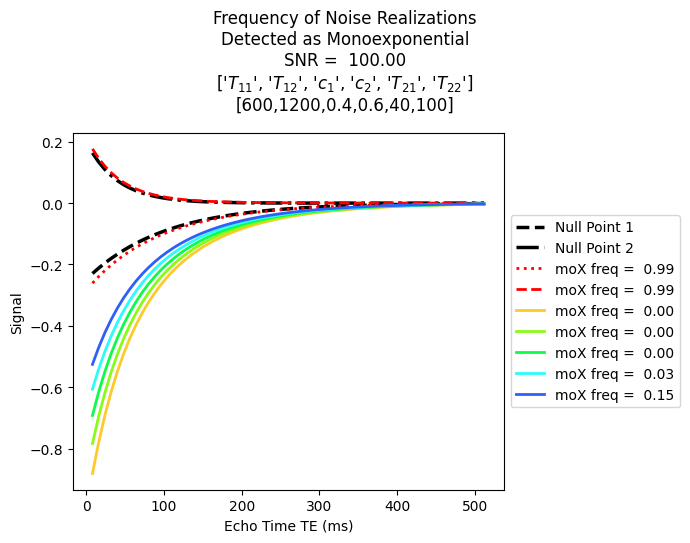

In [26]:
color_array = _get_colors(len(TI_DATA_total)+1)

fig, ax = plt.subplots(1,1, figsize=(7,5.5), tight_layout=True)
fig.suptitle(f"Frequency of Noise Realizations\nDetected as Monoexponential\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p}\n[{T11},{T12},{c1},{c2},{T21},{T22}]")

ax.plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI1star), color = 'k', label = 'Null Point 1', lw = 2.5, ls = '--')
ax.plot(TE_DATA, S_biX_6p(TE_DATA, *true_params, TI = TI2star), color = 'k', label = 'Null Point 2', lw = 2.5, ls = '-.')
ax.plot(TE_DATA, signal_array[0,:], color = 'r', ls = ':', lw = 2, label = f'moX freq = {moX_assess_array[0]/var_reps: .2f}')
ax.plot(TE_DATA, signal_array[1,:], color = 'r', ls = '--', lw = 2, label = f'moX freq = {moX_assess_array[1]/var_reps: .2f}')
for iter in range(len(TI_DATA_total)-2):
    ax.plot(TE_DATA, signal_array[iter+2,:], lw = 2, label = f'moX freq = {moX_assess_array[iter+2]/var_reps: .2f}', color = color_array[iter+1])

ax.set_xlabel('Echo Time TE (ms)')
ax.set_ylabel('Signal')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

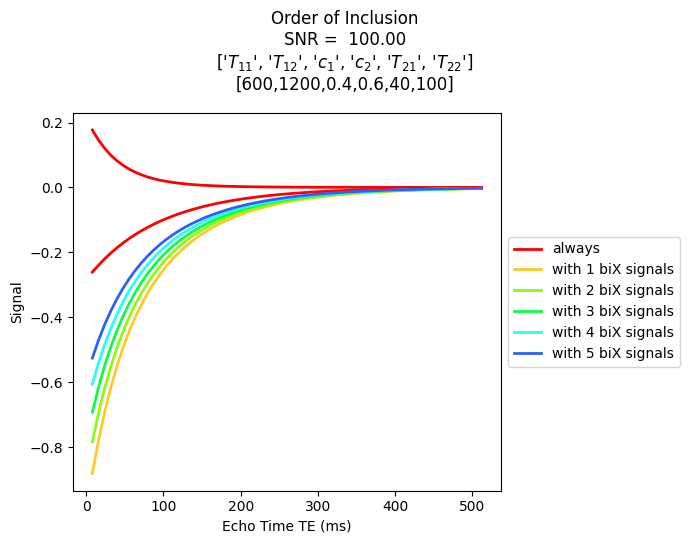

In [27]:
fig, ax = plt.subplots(1,1, figsize=(7,5.5), tight_layout=True)
fig.suptitle(f"Order of Inclusion\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p}\n[{T11},{T12},{c1},{c2},{T21},{T22}]")



ax.plot(TE_DATA, signal_array[0,:], lw = 2, color = 'r')
ax.plot(TE_DATA, signal_array[1,:], lw = 2, label = f'always', color = 'r')

for iter in range(len(TI_DATA_total)-2):
    ax.plot(TE_DATA, signal_array[iter+2,:], lw = 2, label = f'with {iter+1} biX signals', color = color_array[iter+1])

ax.set_xlabel('Echo Time TE (ms)')
ax.set_ylabel('Signal')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

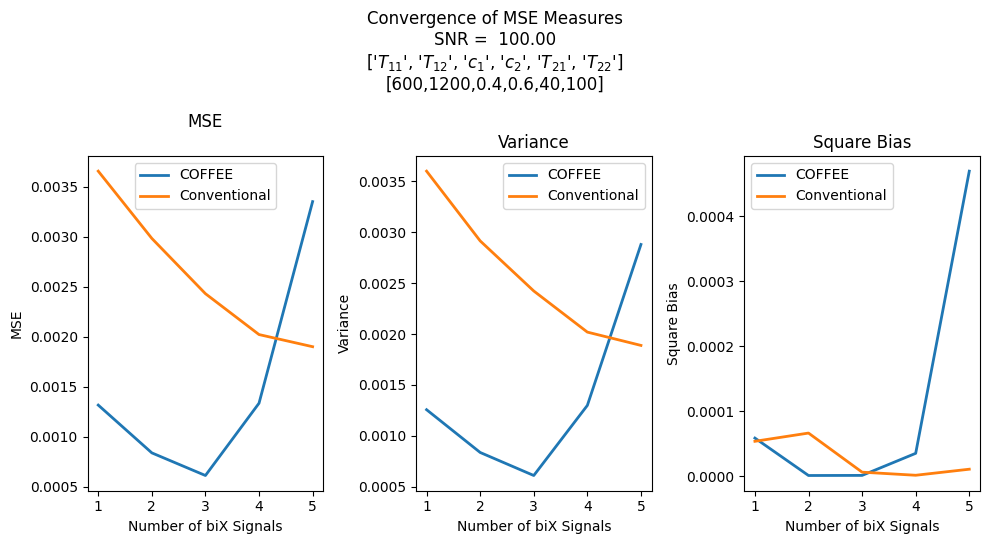

In [28]:
ordering = ["COFFEE", "Conventional", "Curve Fit"]

num_biX = np.arange(1,len(TI_DATA_total)-1,1)

fig, ax = plt.subplots(1,3, figsize=(10,5.5), tight_layout=True)
fig.suptitle(f"Convergence of MSE Measures\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p}\n[{T11},{T12},{c1},{c2},{T21},{T22}]")


for iter in range(2):
    ax[0].plot(num_biX, MSE_nTI[iter,:], lw = 2, label = f'{ordering[iter]}')
ax[0].set_xlabel('Number of biX Signals')
ax[0].set_ylabel('MSE')
ax[0].set_title(f'MSE\n')

ax[0].legend()

for iter in range(2):
    ax[1].plot(num_biX, var_nTI[iter,:], lw = 2, label = f'{ordering[iter]}')
ax[1].set_xlabel('Number of biX Signals')
ax[1].set_ylabel('Variance')
ax[1].set_title('Variance')

ax[1].legend()

for iter in range(2):
    ax[2].plot(num_biX, bias_nTI[iter,:]**2, lw = 2, label = f'{ordering[iter]}')
ax[2].set_xlabel('Number of biX Signals')
ax[2].set_ylabel('Square Bias')
ax[2].set_title('Square Bias')

ax[2].legend()